# Experimenting the Activity Prediction

## Imports, constants, functions

In [1]:
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import copy, datetime, time, os, random
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import plot
import plotly.graph_objs as go

In [2]:
# We need to sleep between the beginning and the end of each new session
SLEEP_TIME=0.001 # in seconds

DEVICES_NAMES=['tablet', 'personal phone','laptop', 'computer',
         'workstation', 'fridge', 'toaster', 'profesional phone',
        "mom's laptop", "old tablet", "connected table", "connected cat"]
NUM_DEVICES=len(DEVICES_NAMES)
DEVICES_PROBA=np.array([5, 10, 7, 4,
                        6, 2, 2, 5,
                        2, 1, 3, 3])
if(len(DEVICES_PROBA) != NUM_DEVICES):
    print("Devices is not the same length as DEVICES_PROBA; aborting.")
    exit(1)
DEVICES_PROBA=DEVICES_PROBA/DEVICES_PROBA.sum()

print("Probability of using each device (there are {}):".format(NUM_DEVICES))
for dp, d in zip(DEVICES_PROBA, DEVICES_NAMES):
    print("\t{}: {:.2%}".format(d, dp))

Probability of using each device (there are 12):
	tablet: 10.00%
	personal phone: 20.00%
	laptop: 14.00%
	computer: 8.00%
	workstation: 12.00%
	fridge: 4.00%
	toaster: 4.00%
	profesional phone: 10.00%
	mom's laptop: 4.00%
	old tablet: 2.00%
	connected table: 6.00%
	connected cat: 6.00%


In [3]:
def generate_devices_sequence(devices_proba, sequence_length):
    num_devices=len(devices_proba)
    
    S=[None]*sequence_length
    for i in range(sequence_length):
        # The sequence only contains different devices
        d_id=np.random.choice(a=range(num_devices), p=devices_proba)
        while i > 0 and d_id == S[i-1][0]:
            d_id=np.random.choice(a=range(num_devices), p=devices_proba)
        t1=datetime.datetime.now()
        time.sleep(SLEEP_TIME)
        S[i]=(d_id, t1, datetime.datetime.now())
    
    return S

def generate_transition_matrix(S, num_devices):
    sequence_length=len(S)
    
    W=np.zeros((num_devices, num_devices), dtype=np.uint)
    for i in range(sequence_length-1):
        W[S[i][0], S[i+1][0]]+=1
    
    W=(W.T/W.sum(axis=1)).T
    W=np.nan_to_num(W)
    
    return W
    

def write_dot_markov_chain(devices_names, W, fn="markov/mc.dot"):
    # Code taken here: http://vknight.org/unpeudemath/code/2015/11/15/Visualising-markov-chains.html

    G = nx.MultiDiGraph(name="Complete transition chain")
    for i, name in enumerate(devices_names):
        G.add_node(i, label=name)
    #G.add_nodes_from(DEVICES_NAMES)

    for i, origin_state in enumerate(devices_names):
        for j, destination_state in enumerate(devices_names):
            rate = W[i][j]
            if rate > 0:
                G.add_edge(i,
                           j,
                           weight=rate,
                           # For clarity when drawing edge labels
                           decorate=True,
                           label="{:.02f}".format(rate))
                
    write_dot(G, fn)
    
    return G
    
    # You will need to run the following command to create a .png (and a .ps) from the .dot:
    # $ dot -Tps -Goverlap=scale mc.dot -o mc.ps; convert mc.ps mc.png

def random_walk(initial_proba, transition_matrix, length, initial_state=None):
    n=len(initial_proba)
    S=[None]*length
    
    if n != transition_matrix.shape[0] or n != transition_matrix.shape[1]:
        print("Please give me a initial_proba of size N and a transition_matrix of size NxN; aborting.")
        return S
    
    current=initial_state
    if current == None:
        # Initial choice is driven by initial_proba
        current=np.random.choice(a=range(n), p=initial_proba)

    for i in range(length):
        t1=datetime.datetime.now()
        time.sleep(SLEEP_TIME)
        S[i]=(current, t1, datetime.datetime.now())
        # Next choices depend on the transition_matrix
        current=np.random.choice(a=range(n), p=transition_matrix[current])
        
    return S    
        
def session_to_str(s):
    return "{:20} ({:2}) [{} -> {}]".format(DEVICES_NAMES[s[0]], s[0],
                                            s[1].strftime("%H:%M:%S.%f"),
                                            s[2].strftime("%H:%M:%S.%f"))

def get_up_to_date_devices_rate(devices, used_device):
    last_session=devices[used_device].get_last_session()
    
    n_up_to_date=0
    for d in devices:
        if d.get_last_session() == last_session:
            n_up_to_date+=1
            
    return n_up_to_date/len(devices)

# Now that I think of it, this is horribly complicated:
# We could only count missing devices in S to get the number of unused devices
def get_non_connected_rate(S, num_devices):
    G=nx.Graph()
    
    G.add_nodes_from(list(range(num_devices)))
    
    W=generate_transition_matrix(S, num_devices)
    for i in range(num_devices):
        for j in range(num_devices):
            if W[i][j] == 0:
                continue
            G.add_edge(i, j)
    
    return len(list(nx.connected_components(G))[1:])/num_devices

def get_after_transition_vector(S, device_id, num_devices):
    p=np.zeros((num_devices), dtype=np.float)
    for i in range(len(S)-1):
        if S[i][0] == device_id and S[i+1][0] != device_id:
            p[S[i+1][0]]+=1
    #print(p)
    if p.sum() != 0:
        p/=p.sum()
    return p
def get_before_transition_vector(S, device_id, num_devices):
    p=np.zeros((num_devices), dtype=np.float)
    for i in range(1,len(S)):
        if S[i][0] == device_id and S[i-1][0] != device_id:
            p[S[i-1][0]]+=1
    #print(p)
    if p.sum() != 0:
        p/=p.sum()
    return p

def get_max_indices(v, n):
    ret=[]
    for _ in range(n):
        i = np.argmax(v)
        if v[i] == 0:
            return ret
        
        ret.append(i)
        v[i]=0
        
    return ret

def print_devices(devices):
    for d in devices:
        print(d)
    print()
    
def pull_devices(devices):
    # Randomize the pull order to emulate distributed behaviour
    for d in np.random.permutation(devices):
        d.pull_update_from_devices_before()
    
def run_round(devices, device_id):
    devices[device_id].use()
    pull_devices(devices)

## Devices behaviour

In [33]:
# Size of the sets devices_before and devices_after in the Device class
DEVICES_SET_SIZE=4

class Device:
    def __init__(self, device_id, device_name, S_init, devices_set_size):
        self.S = copy.deepcopy(S_init)
        self.device_id = device_id
        self.device_name = device_name
        self.devices_before=[]
        self.devices_after=[]
        self.devices_set_size=devices_set_size
        # Initialises the devices lists
        self.update_devices()
    
    # Use the device: add an entry to its Sequence and push the update
    def use(self):
        t1=datetime.datetime.now()
        time.sleep(SLEEP_TIME)
        session=(self.device_id, t1, datetime.datetime.now())
        self.S.append(session)
        self.update_devices()
        self.push_update_to_devices_after(session)
        
    # Add the session to our Sequence if it is newer than our last
    def receive_update(self, session):
        if self.get_last_timestamp() < session[1]:
            self.S.append(session)
            self.update_devices()
    
    # Push a session to all devices_after
    def push_update_to_devices_after(self, session):
        for d in self.devices_after:
            devices[d].receive_update(session)
    
    # Query all devices_before to check if they have a new session, and pull it if so
    def pull_update_from_devices_before(self):
        for d in self.devices_before:
            if self.S[-1][1] < devices[d].get_last_timestamp():
                self.receive_update(devices[d].get_last_session())
                break
                
    def update_devices(self):
        self.devices_before=get_max_indices(
            get_before_transition_vector(self.S, self.device_id, NUM_DEVICES),
            self.devices_set_size)
        self.devices_after=get_max_indices(
            get_after_transition_vector(self.S, self.device_id, NUM_DEVICES),
            self.devices_set_size)
    
    # getters
    def get_last_timestamp(self):
        return self.S[-1][1]
    def get_last_session(self):
        return self.S[-1]
    
    def __str__(self):
        return "Device{{S[-1]: {s}, name: {n}, id: {i}}}".format(
            n=self.device_name, i=self.device_id, s=session_to_str(self.S[-1]))

## RandDevice: Add a little random

In [4]:
def random_peer_sampling(num_devices, device_id, exclude, size):
    ret=list(range(num_devices))
    # Remove our device id
    ret.remove(device_id)
    # Remove already picked elements
    for x in exclude:
        if x in ret:
            ret.remove(x)
    # Shuffle and return the subset of desired size
    random.shuffle(ret)
    return ret[:size]

class RandDevice:
    def __init__(self, device_id, device_name, S_init,
                 best_devices_set_size, total_devices_set_size):
        self.S = copy.deepcopy(S_init)
        self.device_id = device_id
        self.device_name = device_name
        self.devices_before=[]
        self.devices_after=[]
        self.best_devices_set_size = best_devices_set_size
        self.total_devices_set_size = total_devices_set_size
        # Initialises the devices lists
        self.update_devices()
    
    # Use the device: add an entry to its Sequence and push the update
    def use(self):
        t1=datetime.datetime.now()
        time.sleep(SLEEP_TIME)
        session=(self.device_id, t1, datetime.datetime.now())
        self.S.append(session)
        self.update_devices()
        self.push_update_to_devices_after(session)
        
    # Add the session to our Sequence if it is newer than our last
    def receive_update(self, session):
        if self.get_last_timestamp() < session[1]:
            self.S.append(session)
            self.update_devices()
    
    # Push a session to all devices_after
    def push_update_to_devices_after(self, session):
        for d in self.devices_after:
            devices[d].receive_update(session)
    
    # Query all devices_before to check if they have a new session, and pull it if so
    def pull_update_from_devices_before(self):
        for d in self.devices_before:
            if self.S[-1][1] < devices[d].get_last_timestamp():
                self.receive_update(devices[d].get_last_session())
                break
                
    def update_devices(self):
        # Before/after devices lists are given optimal elements
        self.devices_before=get_max_indices(
            get_before_transition_vector(self.S, self.device_id, NUM_DEVICES),
            self.best_devices_set_size)
        self.devices_after=get_max_indices(
            get_after_transition_vector(self.S, self.device_id, NUM_DEVICES),
            self.best_devices_set_size)
        # And add some random elements to obtain a size of TOTAL_DEVICES_SET_SIZE
        self.devices_before.extend(random_peer_sampling(NUM_DEVICES, self.device_id, 
            exclude=self.devices_before,
            size=self.total_devices_set_size-len(self.devices_before)))
        self.devices_after.extend(random_peer_sampling(NUM_DEVICES, self.device_id, 
            exclude=self.devices_after,
            size=self.total_devices_set_size-len(self.devices_after)))
    
    # getters
    def get_last_timestamp(self):
        return self.S[-1][1]
    def get_last_session(self):
        return self.S[-1]
    
    def __str__(self):
        return "Device{{S[-1]: {s}, name: {n}, id: {i}}}".format(
            n=self.device_name, i=self.device_id, s=session_to_str(self.S[-1]))

## Experiment!

In [7]:
N_EXPERIMENTS=10
MODEL_SEQUENCE_LENGTH=2500
TOTAL_SEQUENCE_LENGTH=100
INITIAL_SEQUENCE_LENGTH=5
N_PULLS=5
ADD_RANDOM=True

print("{} experiments (using a seed sequence of {} sessions), initial sequence length={}, total sequence length={}, number of pulls={}".format(
N_EXPERIMENTS, MODEL_SEQUENCE_LENGTH, INITIAL_SEQUENCE_LENGTH, TOTAL_SEQUENCE_LENGTH, N_PULLS))
#if ADD_RANDOM:
    #print("The 'devices_before' and 'devices_after' sets contain {} devices, among which up to {} are computed,".format(
    #    TOTAL_DEVICES_SET_SIZE, BEST_DEVICES_SET_SIZE)+
    #      " the rest being random.")
#else:
#    print("The 'devices_before' and 'devices_after' sets contain up to {} devices.".format(DEVICES_SET_SIZE))

t_start=datetime.datetime.now()

SEQ_DF_COLUMNS=['experiment_id', 'sequence_length', 'non_connected_rate']
seq_df=pd.DataFrame(columns=SEQ_DF_COLUMNS)
seq_df['experiment_id']=seq_df['experiment_id'].astype(np.int)
seq_df['sequence_length']=seq_df['sequence_length'].astype(np.int)

PULLS_DF_COLUMNS=['experiment_id', 'sequence_length', 'n_pulls', 'up_to_date_rate']
pulls_df = pd.DataFrame(columns=PULLS_DF_COLUMNS)

# We generate a new model N_EXPERIMENTS times
for experiment_id in range(N_EXPERIMENTS):
    # Generation of the model
    W=generate_transition_matrix(
        generate_devices_sequence(DEVICES_PROBA, MODEL_SEQUENCE_LENGTH),
        NUM_DEVICES)
    
    S_total=random_walk(DEVICES_PROBA, W, TOTAL_SEQUENCE_LENGTH)
    S=S_total[:INITIAL_SEQUENCE_LENGTH-1]
    
    devices=[None]*NUM_DEVICES
    for device_id, device_name in enumerate(DEVICES_NAMES):
        if ADD_RANDOM:
            devices[device_id]=RandDevice(device_id, device_name, S)
        else:
            devices[device_id]=Device(device_id, device_name, S)

    for sequence_length in range(INITIAL_SEQUENCE_LENGTH, TOTAL_SEQUENCE_LENGTH):
        # Consume a user interaction
        used_device=S_total[sequence_length][0]
        # .use() updates device_used and performs a push from device_used
        devices[used_device].use()
        S=S_total[:sequence_length]
        
        # Append S's non_connected_rate to seq_df
        seq_df=seq_df.append(pd.Series(dict(
                experiment_id=experiment_id, sequence_length=sequence_length,
                non_connected_rate=get_non_connected_rate(S, NUM_DEVICES))), 
            ignore_index=True)
        
        for n_pulls in range(1, N_PULLS+1):
            # Have all devices pull from their devices_before
            pull_devices(devices)
            
            pulls_df=pulls_df.append(pd.Series(dict(
                    experiment_id=experiment_id, sequence_length=sequence_length, n_pulls=n_pulls,
                    up_to_date_rate=get_up_to_date_devices_rate(devices, used_device))),
                ignore_index=True)
        
    print("[{}] Completed experiment #{}/{}.".format(datetime.datetime.now() - t_start, experiment_id+1, N_EXPERIMENTS))


seq_df['experiment_id']=seq_df['experiment_id'].astype(np.int)
seq_df['sequence_length']=seq_df['sequence_length'].astype(np.int)
pulls_df['experiment_id']=pulls_df['experiment_id'].astype(np.int)
pulls_df['sequence_length']=pulls_df['sequence_length'].astype(np.int)
pulls_df['n_pulls']=pulls_df['n_pulls'].astype(np.int)

10 experiments (using a seed sequence of 2500 sessions), initial sequence length=5, total sequence length=100, number of pulls=5


TypeError: __init__() missing 2 required positional arguments: 'best_devices_set_size' and 'total_devices_set_size'

## Interpreting results

In [9]:
# Creating a plots subdirectory
DIR=os.getcwd()+'/plots/'
print(DIR)

try:
    os.mkdir(DIR)
except FileExistsError:
    for f in os.listdir(DIR):
        if os.path.isfile(f):
            os.remove(DIR+f)
    pass

/home/adrien/ownCloud/Thèse/ait_cyclon/python/plots/


### Non connected rate & up to date rate as a f° of sequence length

In [30]:
sequences_length=seq_df['sequence_length'].unique()
per_sequence_df=pd.DataFrame(index=sequences_length)

STUDIED_PULL=5

per_sequence_df['non_connected_rate_mean']=seq_df[['sequence_length','non_connected_rate']].groupby('sequence_length').mean()
per_sequence_df['non_connected_rate_std']=seq_df[['sequence_length','non_connected_rate']].groupby('sequence_length').std()
per_sequence_df['up_to_date_rate_mean']=pulls_df[pulls_df['n_pulls'] == STUDIED_PULL][['sequence_length','up_to_date_rate']].groupby('sequence_length').mean()
per_sequence_df['up_to_date_rate_std']=pulls_df[pulls_df['n_pulls'] == STUDIED_PULL][['sequence_length','up_to_date_rate']].groupby('sequence_length').std()

per_sequence_df

non_connected_rate_mean  non_connected_rate_std  up_to_date_rate_mean  \
5                  0.650000                0.052705                   1.0   
6                  0.616667                0.070273                   1.0   
7                  0.583333                0.055556                   1.0   
8                  0.525000                0.068606                   1.0   
9                  0.491667                0.072966                   1.0   
10                 0.458333                0.080985                   1.0   
11                 0.425000                0.107224                   1.0   
12                 0.400000                0.102439                   1.0   
13                 0.375000                0.080985                   1.0   
14                 0.341667                0.082869                   1.0   
15                 0.333333                0.078567                   1.0   
16                 0.291667                0.080985                   1.0   
17                 0.275000                0.088279                   1.0   
18                 0.266667                0.086066                   1.0   
19                 0.266667                0.086066                   1.0   
20                 0.258333                0.082869                   1.0   
21                 0.233333                0.094608                   1.0   
22                 0.225000                0.088279                   1.0   
23                 0.216667                0.080508                   1.0   
24                 0.200000                0.058267                   1.0   
25                 0.183333                0.052705                   1.0   
26                 0.183333                0.052705                   1.0   
27                 0.183333                0.052705                   1.0   
28                 0.183333                0.052705                   1.0   
29                 0.175000                0.061489                   1.0   
30                 0.158333                0.061489                   1.0   
31                 0.150000                0.052705                   1.0   
32                 0.141667                0.056246                   1.0   
33                 0.125000                0.080985                   1.0   
34                 0.116667                0.070273                   1.0   
..                      ...                     ...                   ...   
70                 0.016667                0.035136                   1.0   
71                 0.016667                0.035136                   1.0   
72                 0.016667                0.035136                   1.0   
73                 0.016667                0.035136                   1.0   
74                 0.008333                0.026352                   1.0   
75                 0.008333                0.026352                   1.0   
76                 0.008333                0.026352                   1.0   
77                 0.008333                0.026352                   1.0   
78                 0.008333                0.026352                   1.0   
79                 0.008333                0.026352                   1.0   
80                 0.008333                0.026352                   1.0   
81                 0.008333                0.026352                   1.0   
82                 0.008333                0.026352                   1.0   
83                 0.008333                0.026352                   1.0   
84                 0.008333                0.026352                   1.0   
85                 0.008333                0.026352                   1.0   
86                 0.008333                0.026352                   1.0   
87                 0.008333                0.026352                   1.0   
88                 0.008333                0.026352                   1.0   
89                 0.008333                0.026352                   1.0   


In [31]:
print(pulls_df['up_to_date_rate'].mean(), pulls_df['up_to_date_rate'].std())
print(pulls_df[pulls_df['n_pulls'] == STUDIED_PULL]['up_to_date_rate'].mean(), pulls_df[pulls_df['n_pulls'] == STUDIED_PULL]['up_to_date_rate'].std())

0.999421052632 0.00692246506028
1.0 0.0


In [32]:
non_connected_rate=go.Scatter(
    name="Rate of unused devices",
    x=sequences_length,
    y=per_sequence_df['non_connected_rate_mean'],
    error_y=dict(
        type='data',
        array=per_sequence_df['non_connected_rate_std'],
        visible=True,
        thickness=1,
        width=2,
        opacity=0.5
    ),
    mode="lines+markers",
    line = dict(width = 1.5),
    marker=dict(size=3),
)
up_to_date_rate=go.Scatter(
    name="Rate of up-to-date devices after {} pulls".format(STUDIED_PULL),
    x=sequences_length,
    y=per_sequence_df['up_to_date_rate_mean'],
    error_y=dict(
        type='data',
        array=per_sequence_df['up_to_date_rate_std'],
        visible=True,
        thickness=1,
        width=2,
        opacity=0.5
    ),
    mode="lines+markers",
    line = dict(width = 1.5),
    marker=dict(size=3),
)

name="Up to date and unused devices rates as a function of the user sequence length "
name+="averaged over {} experiments with a set size of {}".format(N_EXPERIMENTS, DEVICES_SET_SIZE)
if ADD_RANDOM:
    name+=" WITH {} RANDOM!".format(1-BEST_DEVICES_SET_SIZE/TOTAL_DEVICES_SET_SIZE)
layout=dict(
    title=name,
    xaxis=dict(title='Sequence length'),
    yaxis=dict(title='Rate'),
)

fig=go.Figure(data=[non_connected_rate, up_to_date_rate], layout=layout)
plot(fig, filename=DIR+"per_sequence.html")

'file:///home/adrien/ownCloud/Thèse/ait_cyclon/python/plots/per_sequence.html'

### Rate of up-to-date as a function of unused devices

In [13]:
up_to_date_per_non_connected=per_sequence_df.groupby('non_connected_rate_mean')['up_to_date_rate_mean'].mean()

In [14]:
up_to_date_per_non_connected_trace=go.Scatter(
    x=up_to_date_per_non_connected.index,
    y=up_to_date_per_non_connected.values)

name="Rate of up-to-date devices per rate of unused devices"
if ADD_RANDOM:
    name+=" WITH {} RANDOM!".format(1-BEST_DEVICES_SET_SIZE/TOTAL_DEVICES_SET_SIZE)
layout=dict(
    title=name,
    xaxis=dict(title='Rate of unused devices'),
    yaxis=dict(title='Rate of up-to-date devices'),
)
fig=go.Figure(data=[up_to_date_per_non_connected_trace], layout=layout)
plot(fig, filename=DIR+"up_to_date_per_non_connected.html")

'file:///home/adrien/ownCloud/Thèse/ait_cyclon/python/plots/up_to_date_per_non_connected.html'

### Up to date rate as a f° of the number of pulls

In [28]:
# Group values by experiment_id & sequence_length
grouped=pulls_df.groupby(['experiment_id', 'sequence_length'])
# Perform prev_rate - curr_rate for every group of pulls -> immediate derivate
pulls_df['up_to_date_diff']=grouped['up_to_date_rate'].rolling(window=2, min_periods=1).apply(
    lambda l: l[1]-l[0] if len(l) > 1 else l[0]).values

diff_mean=pulls_df.groupby('n_pulls')['up_to_date_diff'].mean()
diff_std=pulls_df.groupby('n_pulls')['up_to_date_diff'].std()
cnt=(pulls_df['n_pulls'] == 1).sum()

In [29]:
up_to_date_rate_diff=go.Scatter(
    name="Increase of rate",
    x=pulls_df['n_pulls'].unique(),
    y=diff_mean,
    error_y=dict(
        type='data',
        array=diff_std,
        visible=True,
        thickness=1,
        width=2,
        opacity=1
    ),
    mode="lines+markers",
    line = dict(width = 1.5),
    marker=dict(size=3),
)

name="Increase of the rate of up-to-date devices over successive pull round, averaged over {} session updates.".format(cnt)
if ADD_RANDOM:
    name+=" WITH {} RANDOM!".format(1-BEST_DEVICES_SET_SIZE/TOTAL_DEVICES_SET_SIZE)
layout=dict(
    title=name,
    xaxis=dict(title='Number of pull rounds'),
    yaxis=dict(
        title='Rate',
        #type='log',
        #autorange=True
    ),
)
fig=go.Figure(data=[up_to_date_rate_diff], layout=layout)
plot(fig, filename=DIR+"increase_of_rate.html")

'file:///home/adrien/ownCloud/Thèse/ait_cyclon/python/plots/increase_of_rate.html'

## Run some rounds and display the before/after devices relationship graphs

In [ ]:
DEVICES_DF_COLUMNS=["device_id", "n_round", "session", "devices_before", "devices_after", "up_to_date", "device_used"]
def save_devices_state(devices, n_round, devices_df, last_session=None):
    for d in devices:
        up_to_date=True
        device_used=NUM_DEVICES
        if last_session is not None:
            up_to_date= (d.S[-1] == last_session)
            device_used=last_session[0]
        item=pd.Series(dict(
            device_id=d.device_id, n_round=n_round, session=d.S[-1],
            devices_before=tuple(d.devices_before), devices_after=tuple(d.devices_after),
            up_to_date=up_to_date,
            device_used=device_used))
        devices_df = devices_df.append(item, ignore_index=True)
        
    return devices_df

In [14]:
# Create the devices
devices=[None]*NUM_DEVICES

for device_id, device_name in enumerate(DEVICES_NAMES):
    devices[device_id]=Device(device_id, device_name, S)

# Create the user sequence
user_sequence=random_walk(DEVICES_PROBA, W_global, USER_SEQUENCE_LENGTH+1, S[-1][0])
# We remove the first ession, because it's equal to the last in S
user_sequence=user_sequence[1:]

# Create the dataframe
devices_df=pd.DataFrame(columns=DEVICES_DF_COLUMNS)
devices_df['device_id']=devices_df['device_id'].astype(np.int)
devices_df['n_round']=devices_df['n_round'].astype(np.int)
devices_df['device_used']=devices_df['device_used'].astype(np.int)

# And run the simulation
devices_df = save_devices_state(devices, 0, devices_df)
for n_round, session in enumerate(user_sequence):
    print("[{}] Alice decided to use her {}.".format(n_round, DEVICES_NAMES[session[0]]))
    
    run_round(devices, session[0])
    
    last_session = devices[session[0]].S[-1]
    
    devices_df = save_devices_state(devices, n_round+1, devices_df, last_session)
    
devices_df

[0] Alice decided to use her workstation.
[1] Alice decided to use her profesional phone.
[2] Alice decided to use her old tablet.
[3] Alice decided to use her connected cat.
[4] Alice decided to use her connected table.
[5] Alice decided to use her laptop.
[6] Alice decided to use her connected cat.
[7] Alice decided to use her tablet.
[8] Alice decided to use her laptop.
[9] Alice decided to use her personal phone.
[10] Alice decided to use her workstation.
[11] Alice decided to use her old tablet.
[12] Alice decided to use her workstation.
[13] Alice decided to use her personal phone.
[14] Alice decided to use her workstation.
[15] Alice decided to use her connected cat.
[16] Alice decided to use her tablet.
[17] Alice decided to use her workstation.
[18] Alice decided to use her profesional phone.
[19] Alice decided to use her laptop.


device_id  n_round                                            session  \
0            0        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
1            1        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
2            2        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
3            3        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
4            4        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
5            5        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
6            6        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
7            7        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
8            8        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
9            9        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
10          10        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
11          11        0  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
12           0        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
13           1        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
14           2        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
15           3        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
16           4        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
17           5        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
18           6        1  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
19           7        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
20           8        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
21           9        1  (5, 2017-05-15 10:18:20.257595, 2017-05-15 10:...   
22          10        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
23          11        1  (4, 2017-05-15 10:18:23.697096, 2017-05-15 10:...   
24           0        2  (7, 2017-05-15 10:18:23.735816, 2017-05-15 10:...   
25           1        2  (7, 2017-05-15 10:18:23.735816, 2017-05-15 10:...   
26           2        2  (7, 2017-05-15 10:18:23.735816, 2017-05-15 10:...   
27           3        2  (7, 2017-05-15 10:18:23.735816, 2017-05-15 10:...   
28           4        2  (7, 2017-05-15 10:18:23.735816, 2017-05-15 10:...   
29           5        2  (7, 2017-05-15 10:18:23.735816, 2017-05-15 10:...   
..         ...      ...                                                ...   
222          6       18  (0, 2017-05-15 10:18:24.309495, 2017-05-15 10:...   
223          7       18  (4, 2017-05-15 10:18:24.358307, 2017-05-15 10:...   
224          8       18  (4, 2017-05-15 10:18:24.358307, 2017-05-15 10:...   
225          9       18  (4, 2017-05-15 10:18:24.358307, 2017-05-15 10:...   
226         10       18  (4, 2017-05-15 10:18:24.358307, 2017-05-15 10:...   
227         11       18  (4, 2017-05-15 10:18:24.358307, 2017-05-15 10:...   
228          0       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
229          1       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
230          2       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
231          3       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
232          4       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
233          5       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
234          6       19  (4, 2017-05-15 10:18:24.358307, 2017-05-15 10:...   
235          7       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
236          8       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
237          9       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
238         10       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
239         11       19  (7, 2017-05-15 10:18:24.405636, 2017-05-15 10:...   
240          0       20  (2, 2017-05-15 10:18:24.443343, 2017-05-15 10:...   
241          1       20  (2

### Display rounds

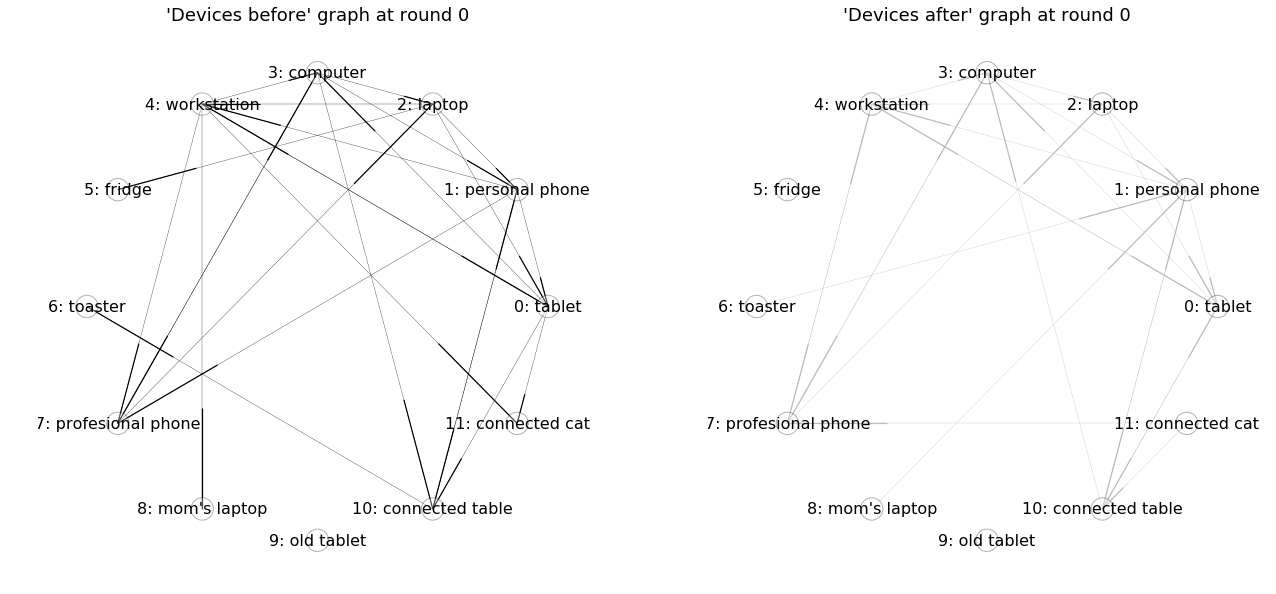

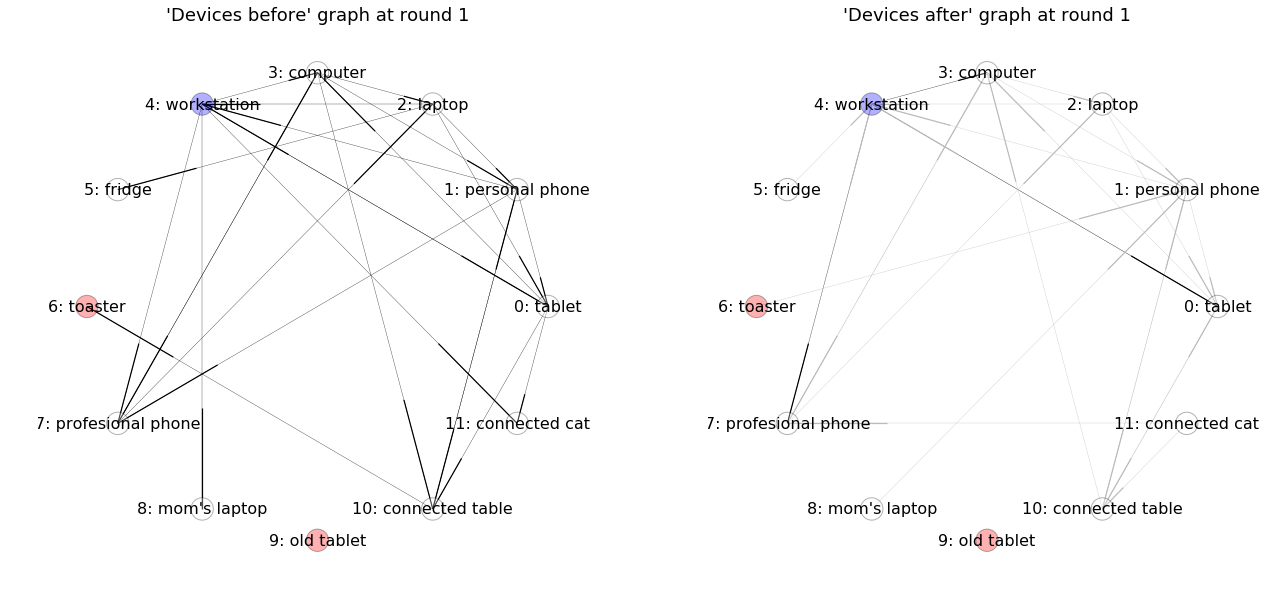

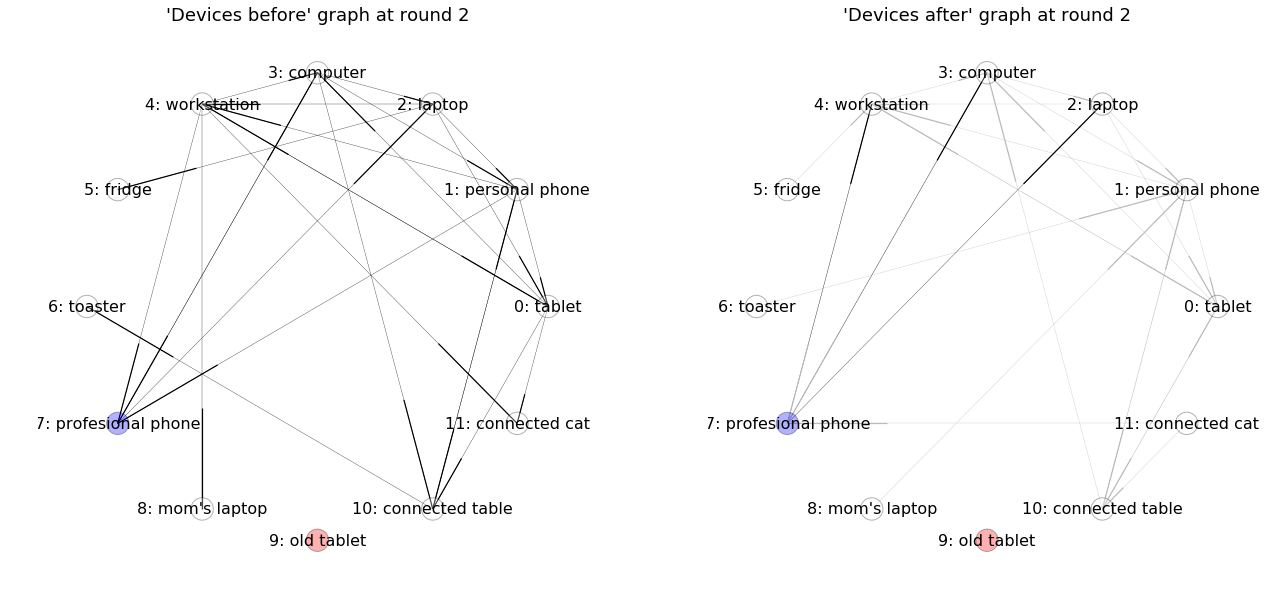

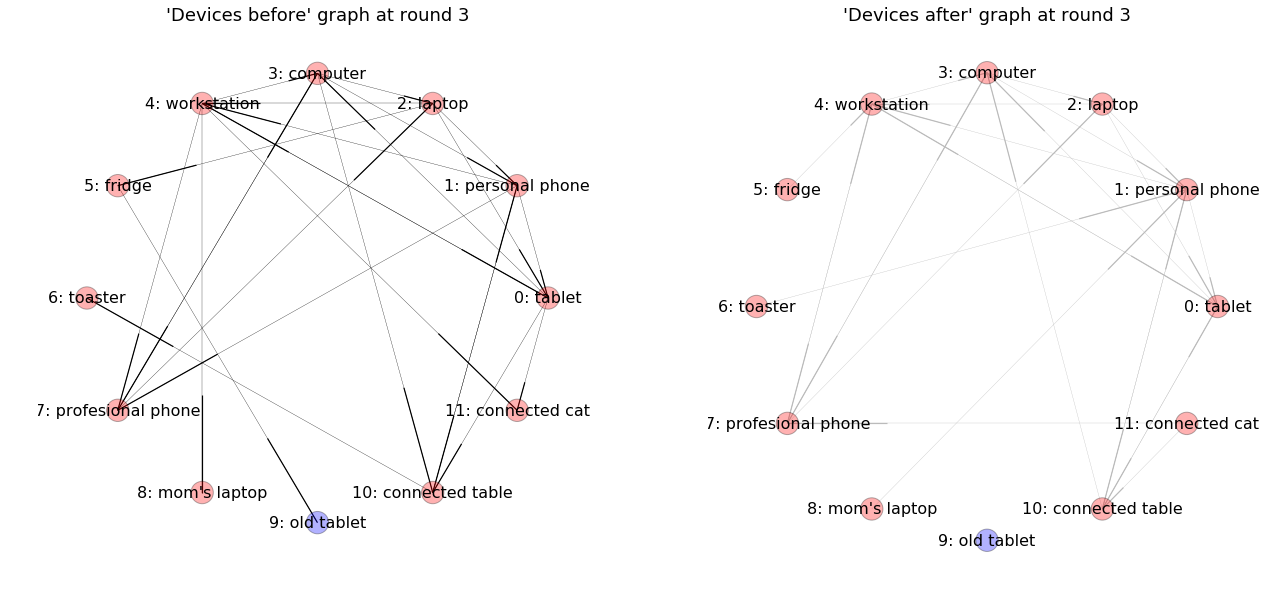

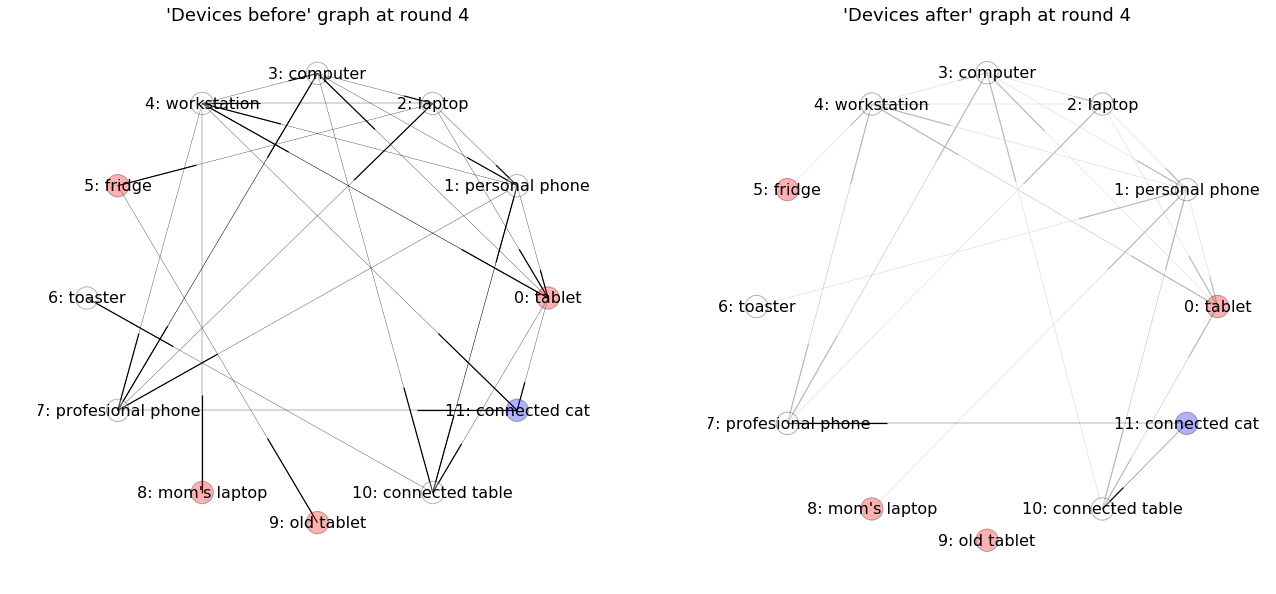

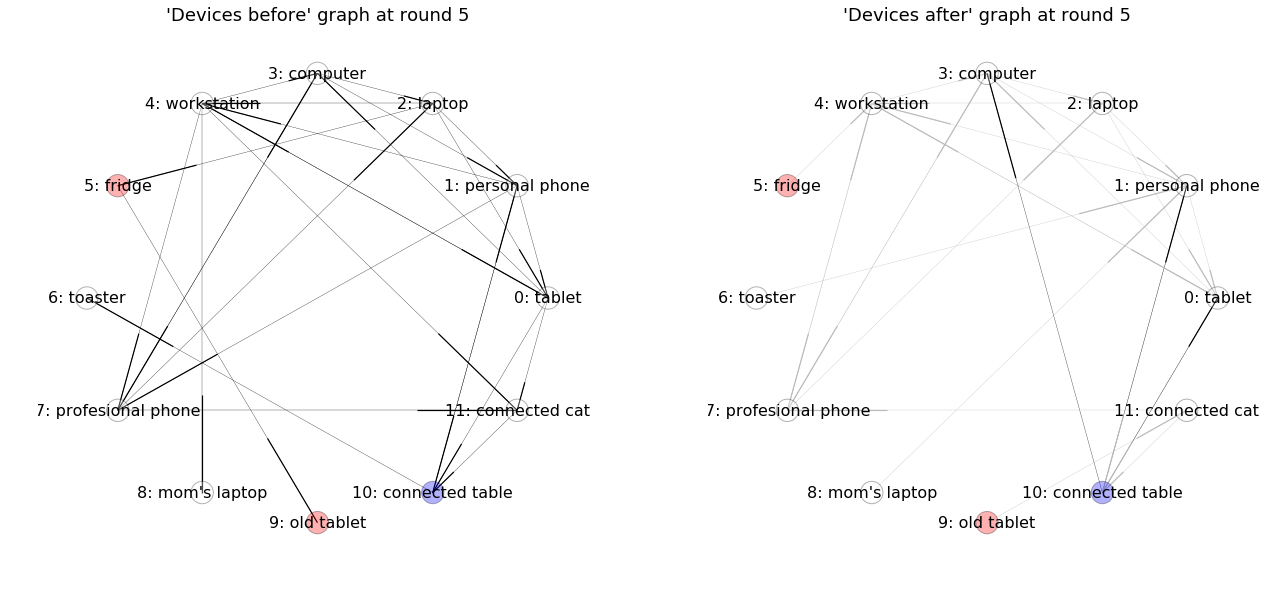

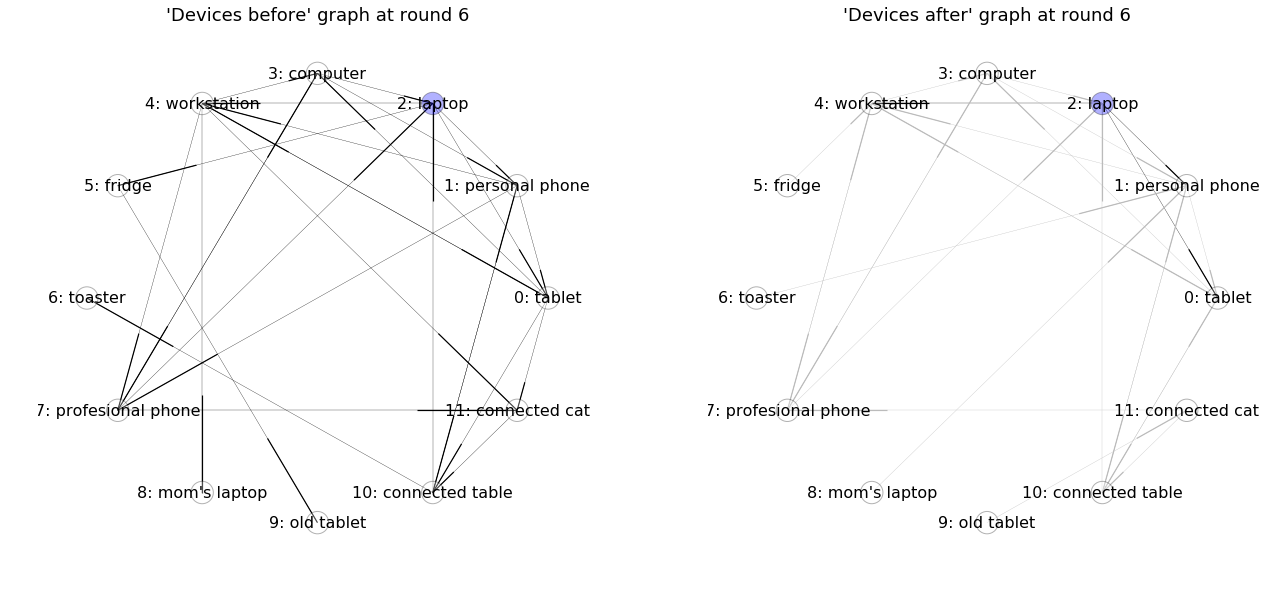

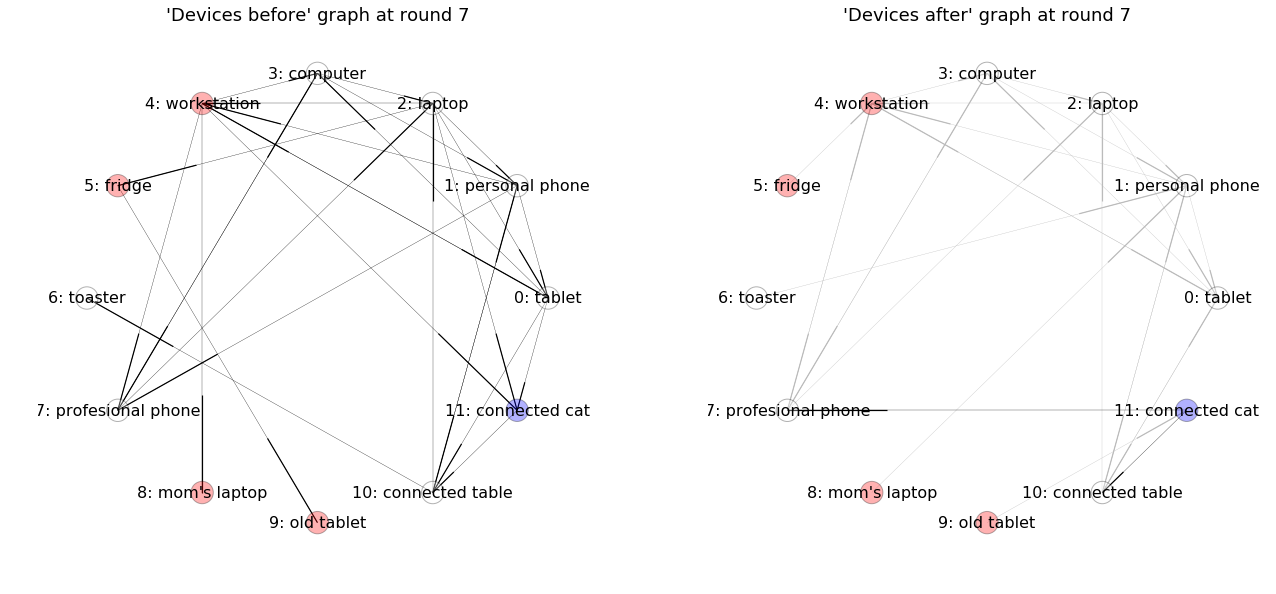

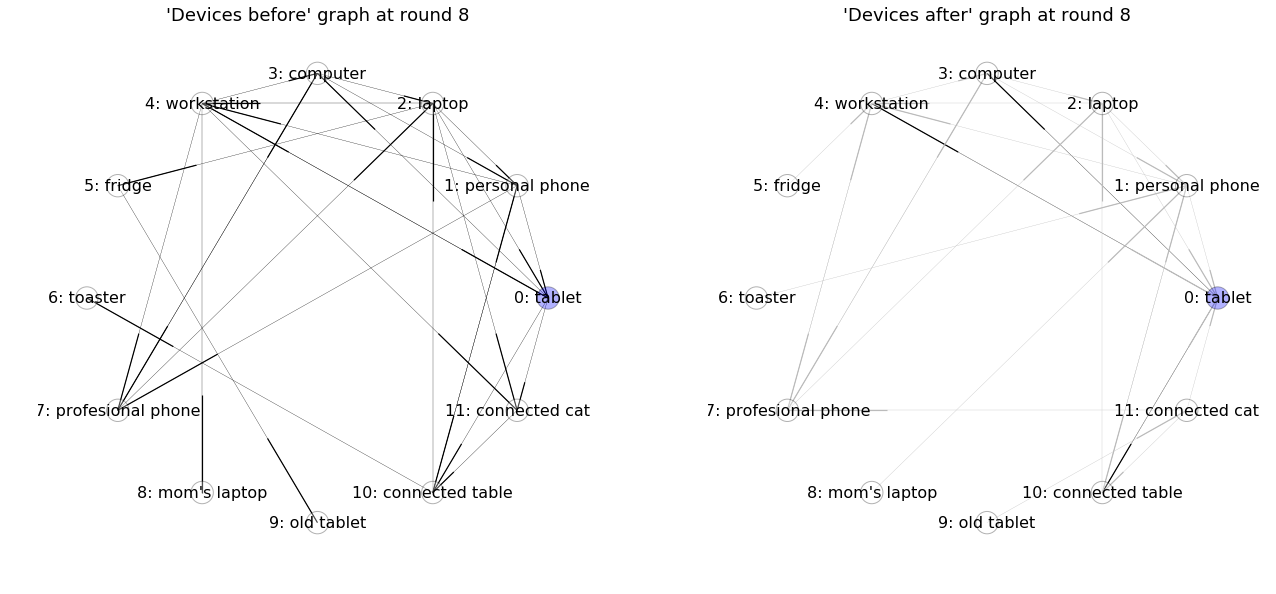

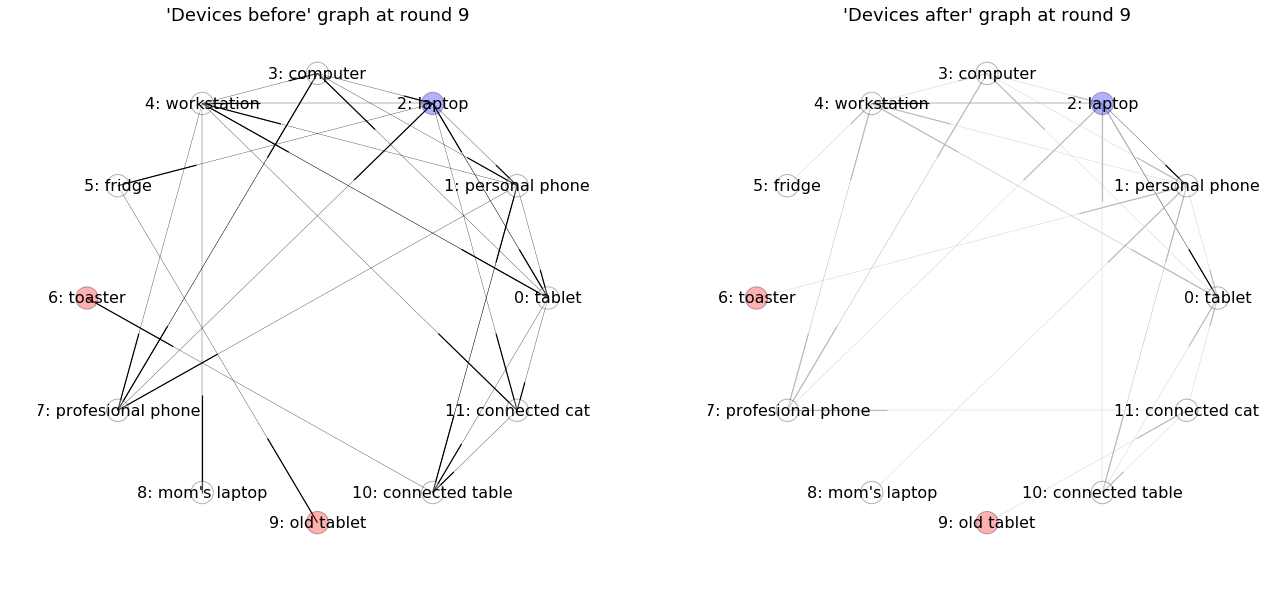

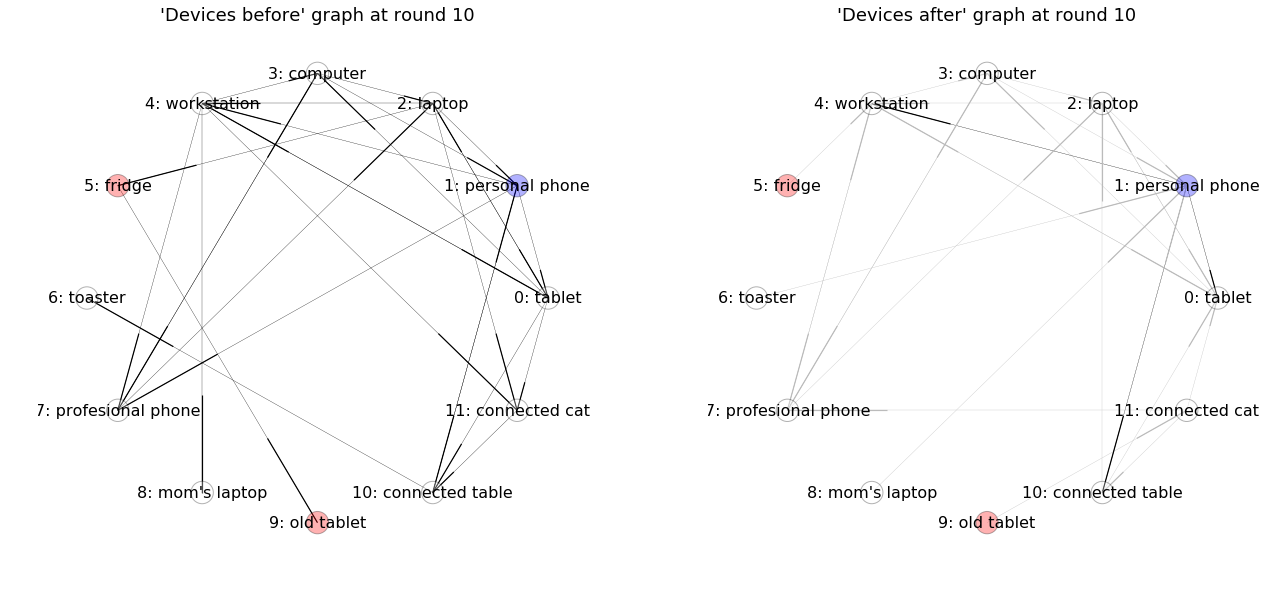

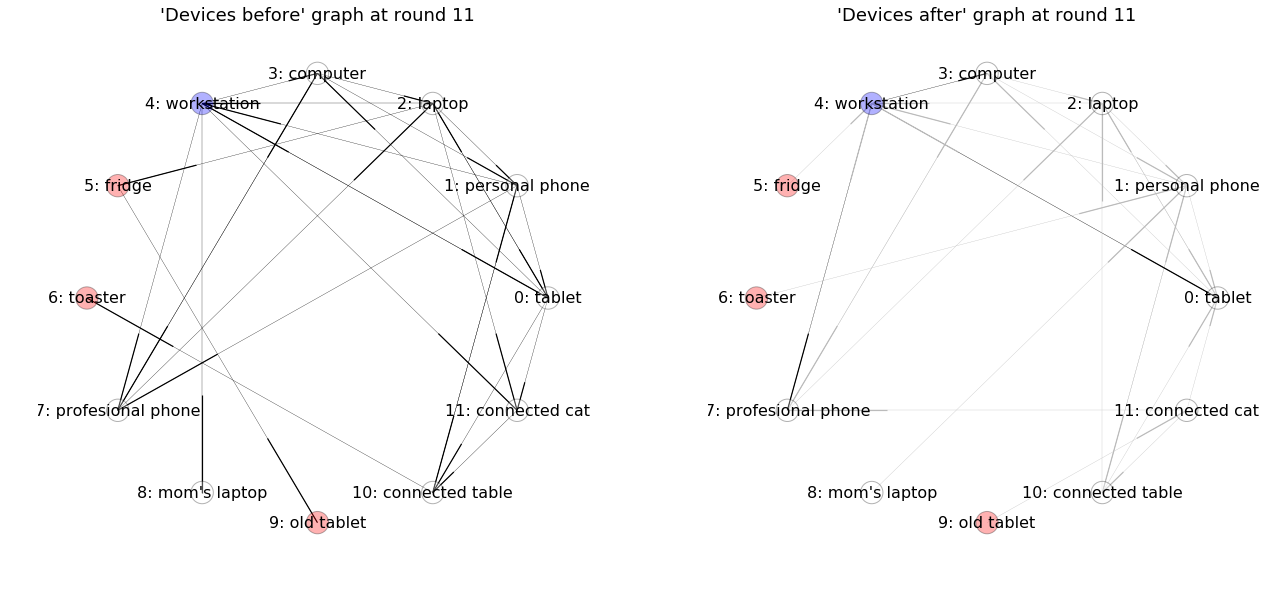

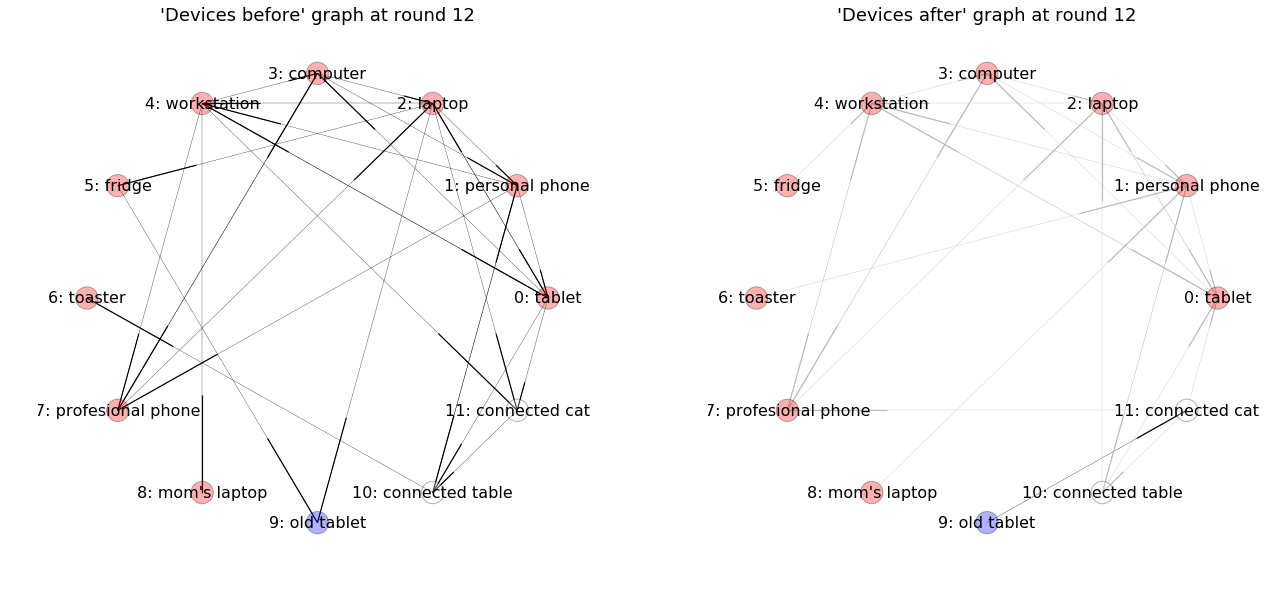

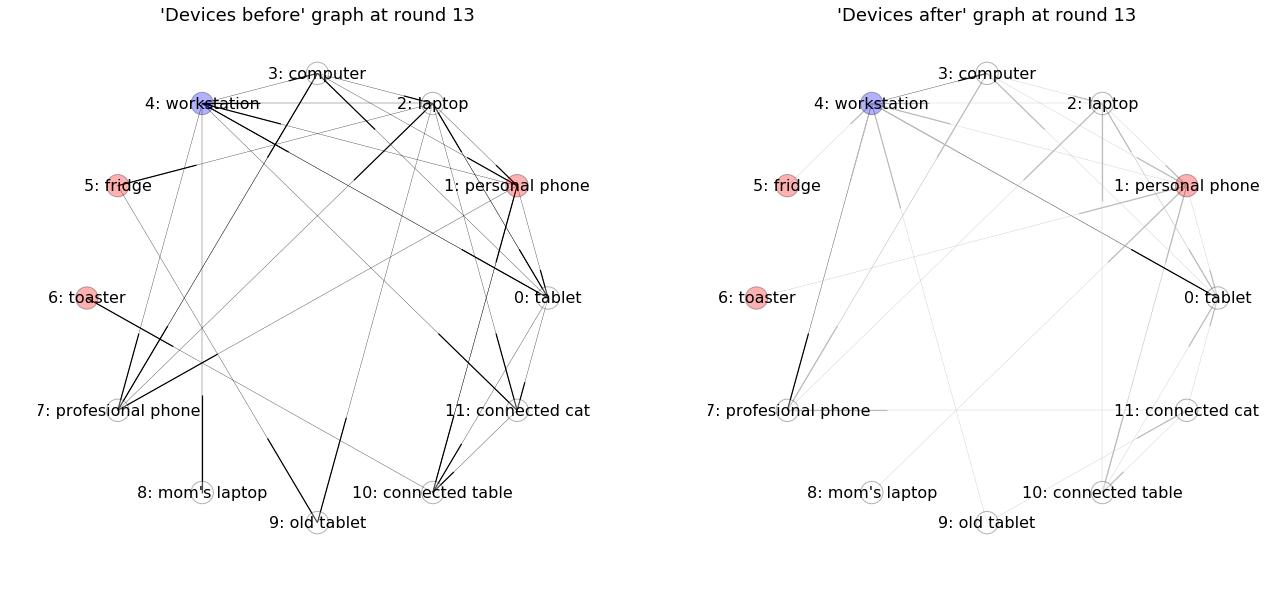

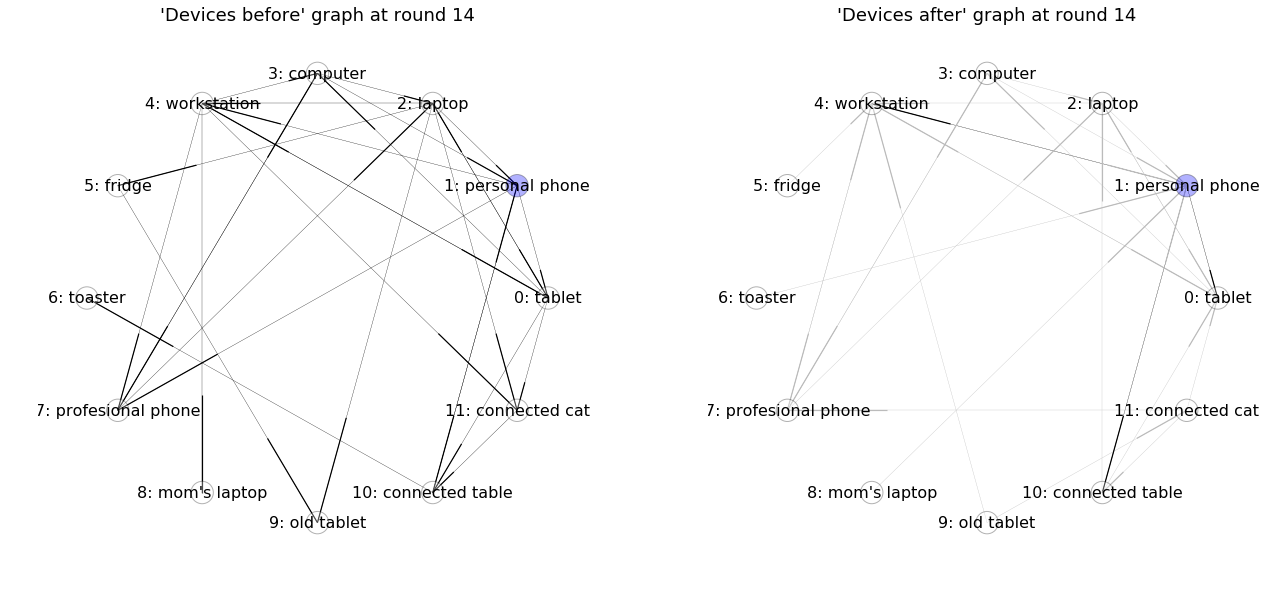

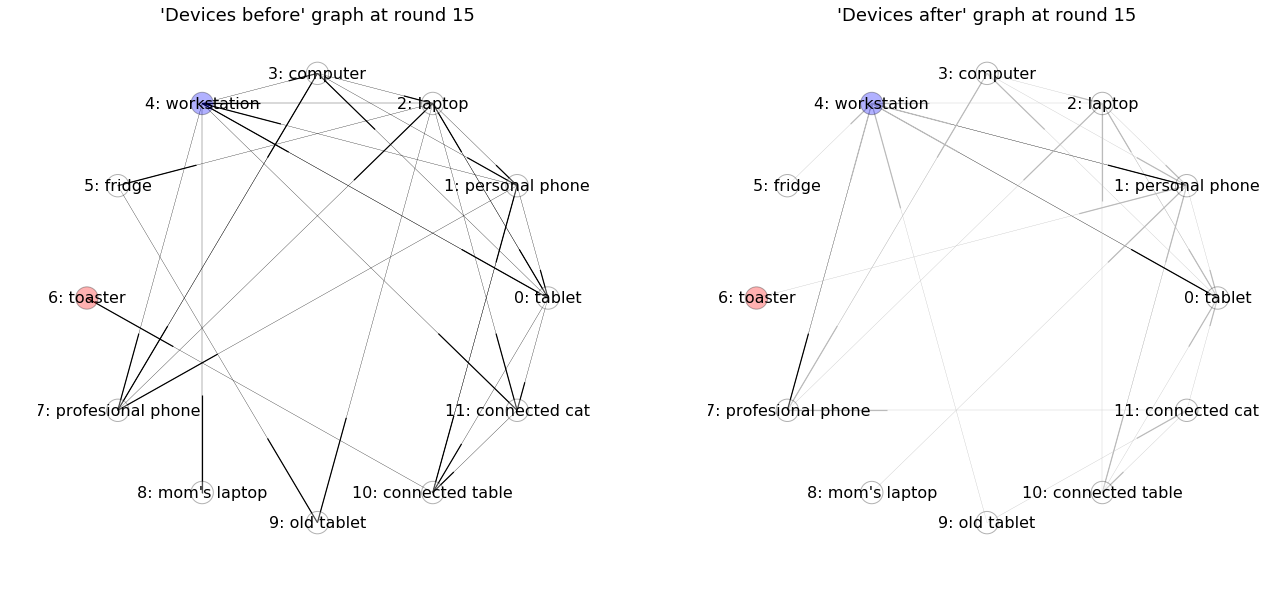

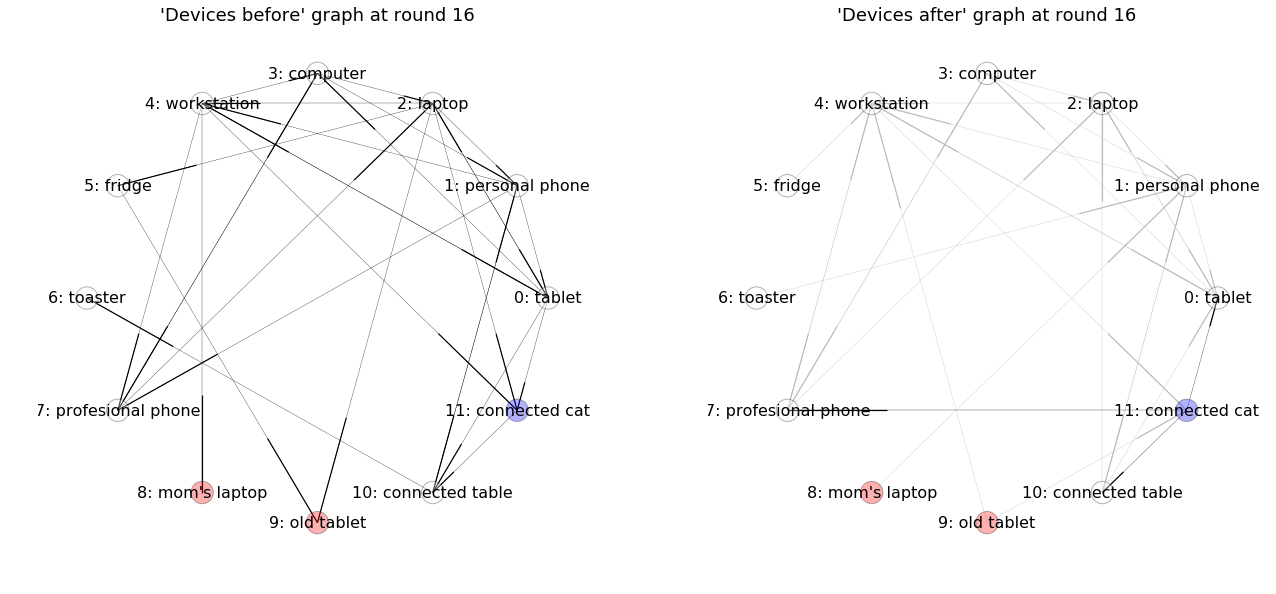

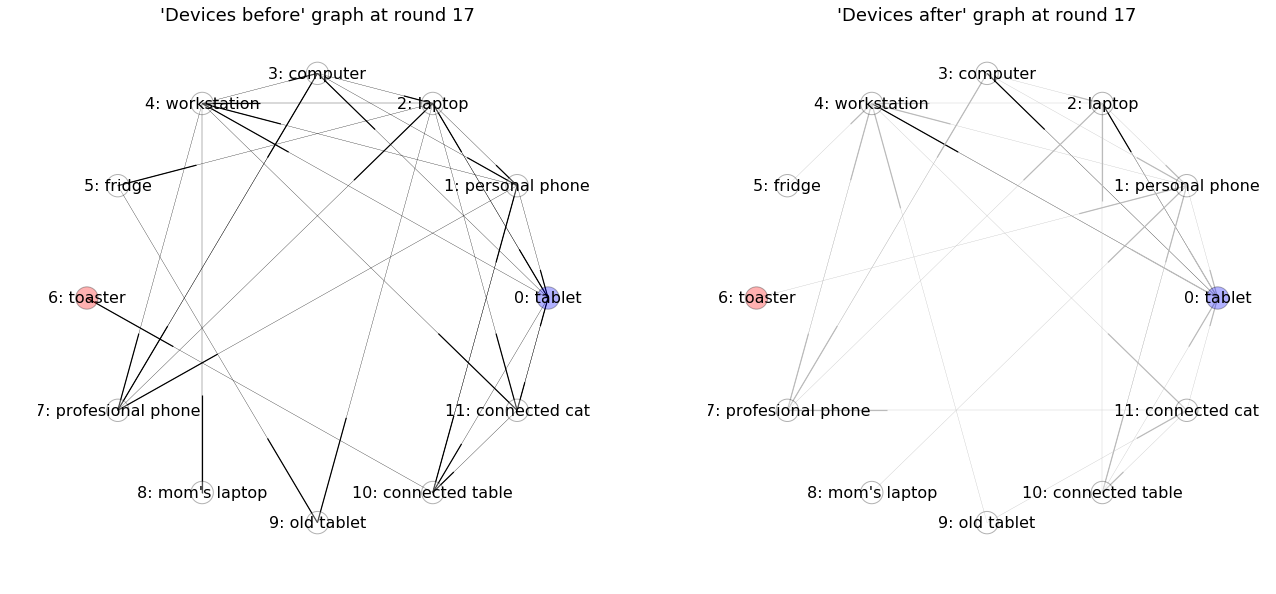

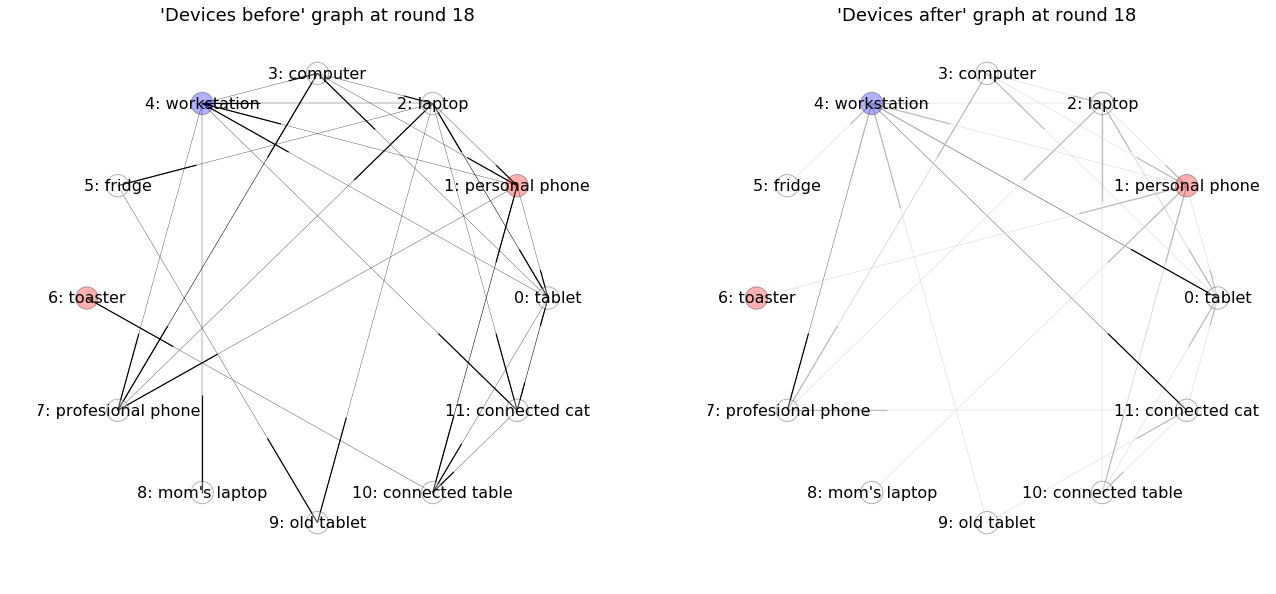

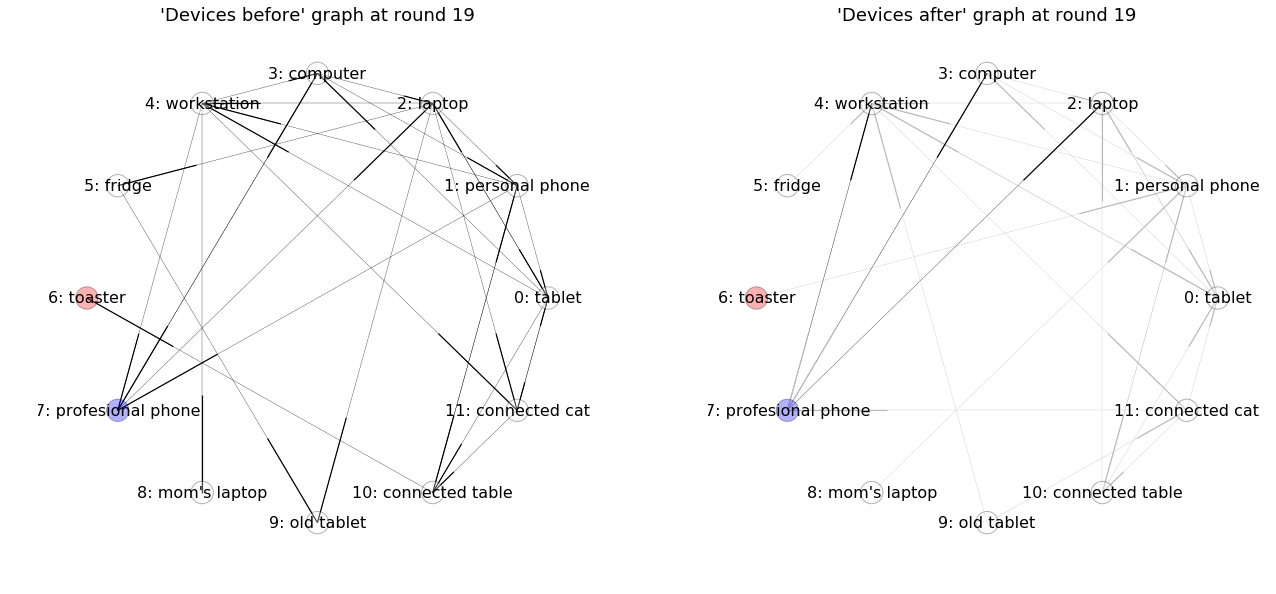

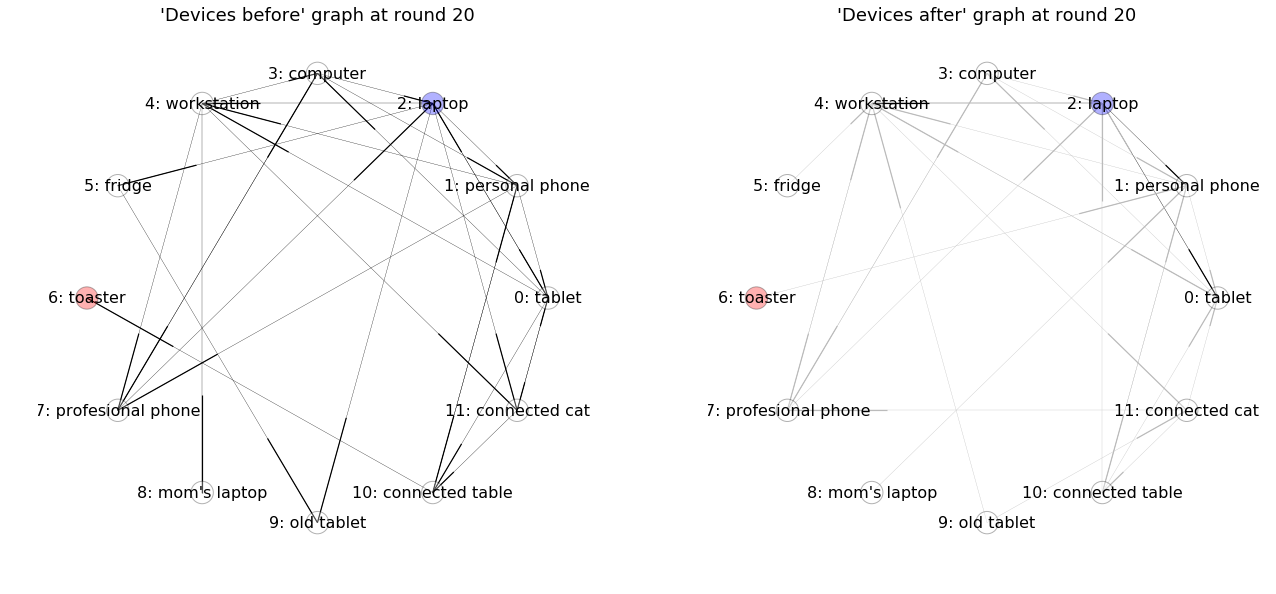

In [36]:
# Constants for drawing
pos=nx.circular_layout(G)    
nodes_label=dict()
for i, name in enumerate(DEVICES_NAMES):
    nodes_label[i]="{}: {}".format(i, name)
    
UNUSED_EDGE_COLOR='#bbbbbb'
USED_EDGE_COLOR='black'

def plot_graph(G, nodes_color, nodes_label, edges_color=None):
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=nodes_color, alpha=0.3, node_size=500)
    nodes.set_edgecolor('black')
    if edges_color is None:
        nx.draw_networkx_edges(G, pos=pos, width=0.3, edge_color='black')
    else:
        nx.draw_networkx_edges(G, pos=pos, width=0.3, edge_color=edges_color)
    nx.draw_networkx_labels(G, pos=pos, labels=nodes_label, font_size=16)

    plt.title(G.name, {'fontsize': 18})
    plt.axis('off')

def draw_devices_graphs(devices_df, n_round):
    G_before=nx.MultiDiGraph(name="'Devices before' graph at round {}".format(n_round))
    G_after=nx.MultiDiGraph(name="'Devices after' graph at round {}".format(n_round))

    G_before.add_nodes_from(range(NUM_DEVICES))
    G_after.add_nodes_from(range(NUM_DEVICES))

    nodes_color=[]
    after_edges_color=[]
    for _, entry in devices_df[devices_df['n_round'] == n_round].iterrows():
        # G_before edges go from the device_before node to the studied one
        for before_id in entry['devices_before']:
            G_before.add_edge(before_id, entry['device_id'])
        
        # G_after edges go from the studied node to the device_after
        for after_id in entry['devices_after']:
            G_after.add_edge(entry['device_id'], after_id)
            if entry['device_id'] == entry['device_used']:
                after_edges_color.append(USED_EDGE_COLOR)
            else:
                after_edges_color.append(UNUSED_EDGE_COLOR)
        
        nodes_color.append('w' if entry['up_to_date'] else 'r')
        
    device_used=devices_df[devices_df['n_round'] == n_round].iloc[0]['device_used']
    if device_used != NUM_DEVICES:
        nodes_color[device_used] = 'b'
    
    plt.figure(figsize=(22,10))
    plt.subplot(121)
    plot_graph(G_before, nodes_color, nodes_label)
    plt.subplot(122)
    plot_graph(G_after, nodes_color, nodes_label, after_edges_color)
    plt.show()
    plt.close()
    
for n_round in devices_df['n_round'].unique():
    draw_devices_graphs(devices_df, n_round)